In [193]:
%matplotlib inline

In [117]:
import sys
import os
from skimage import io, measure, transform, feature
from scipy.ndimage.filters import gaussian_filter
from matplotlib import pyplot as plt
import cv2
import numpy as np

In [206]:
def read_and_sort_images(images_dir):
    images, descs = [], []
    orb = cv2.ORB_create()
    for image_file in os.listdir(images_dir):
        img = io.imread(os.path.join(images_dir, image_file))
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        kp, des = orb.detectAndCompute(gray, None)
        images.append(img)
        descs.append(des)
    matches = np.zeros((len(images), len(images)))
    for i in range(len(images)):
        for j in range(i + 1, len(images)):
            match = feature.match_descriptors(descs[i], descs[j], cross_check=True)
            matches[i][j] = match.shape[0]
            matches[j][i] = match.shape[0]
    i = 0
    sorted_images = [images[i]]
    stack = range(len(images))
    stack.remove(i)
    while len(stack):
        jmax = np.argmax(matches[i])
        matches[:, jmax] = 0
        i = jmax
        sorted_images.append(images[jmax])
        stack.remove(jmax)
    return sorted_images


def match_images(base_img, curr_img):
    gray1 = cv2.cvtColor(base_img, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(curr_img, cv2.COLOR_RGB2GRAY)
    kp1, des1 = orb.detectAndCompute(gray1,None)
    kp2, des2 = orb.detectAndCompute(gray2,None)
    matches = feature.match_descriptors(des1, des2, cross_check=True)
    kps1 = np.stack(np.vectorize(lambda kp: (kp.pt[1], kp.pt[0]))(np.array(kp1)), axis=1)
    kps2 = np.stack(np.vectorize(lambda kp: (kp.pt[1], kp.pt[0]))(np.array(kp2)), axis=1)
    transformation, mask = measure.ransac([kps2[:, ::-1][matches[:, 1]], kps1[:, ::-1][matches[:, 0]]],
                                            transform.ProjectiveTransform, min_samples=4, residual_threshold=5)
#     h, w = base_img.shape[0], base_img.shape[1]
#     old_corners = np.array([[0, 0], [0, h], [w, 0], [h, w]])
#     transformed_corners = transformation(old_corners)
#     corners = np.concatenate((transformed_corners, old_corners))
    
    
    panoram_shape = (2000, 4000)
#     offsets = (abs(np.min(corners[:, 0])), abs(np.min(corners[:, 1])))
#     offset = transform.SimilarityTransform(translation=offsets)
    offset = transform.SimilarityTransform()
    transformed_img1 = transform.warp(base_img, offset.inverse, output_shape=panoram_shape)
    transformed_img2 = transform.warp(curr_img, (transformation + offset).inverse, output_shape=panoram_shape)
    
    mask1 = np.zeros(transformed_img1.shape)
    mask1[transformed_img1 > 0] = 1
    mask1 = np.sum(mask1, axis=2) / 3
    mask2 = np.zeros(transformed_img2.shape)
    mask2[transformed_img2 > 0] = 1
    mask2 = np.sum(mask2, axis=2) / 3
    mask = np.logical_and(mask1, mask2)
    
    panoram = transformed_img1 + transformed_img2
    panoram[mask == 1] /= 2
    return panoram, transformed_img1, transformed_img2


def transform_images(sorted_images, base_idx):
    transformed_images_left = []
    transformed_images_right = []
    _, transformed_img, _ = match_images(sorted_images[base_idx], sorted_images[base_idx + 1])
    transformed_images_left.append(transformed_img)
    for i in range(base_idx + 1, len(sorted_images) - 1):
        _, _, transformed_img = match_images((transformed_img * 255).astype(np.uint8), sorted_images[i])
        transformed_images_left.append(transformed_img)
    transformed_img = sorted_images[base_idx] / 255.
    for i in range(base_idx - 1, -1, -1):
        _, _, transformed_img = match_images((transformed_img * 255).astype(np.uint8), sorted_images[i])
        transformed_images_right.append(transformed_img)
    return np.concatenate([transformed_images_left[::-1], transformed_images_right])


def illustrate_panoram(images, with_pyramid=True):
    panoram = images[0]
    for i in range(1, len(images)):
        if with_pyramid:
            mask = np.zeros(images[i].shape)
            mask[images[i] > 0.1] = 1
            gp = gaussian_pyramid(mask)
            lpi = laplacian_pyramid(images[i])
            lpp = laplacian_pyramid(panoram)
            panoram = np.zeros(lpp[0].shape)
            for k in range(len(lpp)):
                panoram = upsample(panoram)[:lpp[k].shape[0], :lpp[k].shape[1]]
                panoram += gp[k] * lpi[k] + (1 - gp[k]) * lpp[k]
        else:
            panoram = compute_match_mask(panoram, images[i])
    return panoram


def compute_match_mask(img1, img2):
    mask1 = np.zeros(img1.shape)
    mask1[img1 > 0] = 1
    mask1 = np.sum(mask1, axis=2) / 3
    mask2 = np.zeros(img2.shape)
    mask2[img2 > 0] = 1
    mask2 = np.sum(mask2, axis=2) / 3
    mask = np.logical_and(mask1, mask2)
    
    panoram = img1 + img2
    panoram[mask == 1] /= 2
    return panoram


def gaussian_pyramid(img, num_layers=4):
    image = img.copy()
    layers = [gaussian_filter(image, sigma=2)]
    for i in range(num_layers):
        image = gaussian_filter(image, sigma=7)[::2, ::2, :]
        layers.append(image)
    return layers[::-1]


def laplacian_pyramid(img, num_layers=4):
    image = img.copy()
    layers = []
    for i in range(num_layers):
        updown = upsample(image[::2, ::2, :], sigma=num_layers)[:image.shape[0], :image.shape[1]]
        layers.append(image - updown)
        image = image[::2, ::2, :]
    layers.append(image)
    return layers[::-1]


def upsample(img, sigma=7):
    image = np.zeros((img.shape[0] * 2, img.shape[1] * 2, 3))
    for i in range(0, image.shape[0], 2):
        for j in range(0, image.shape[1], 2):
            image[i, j] = img[i / 2, j / 2]
    return gaussian_filter(image, sigma=sigma)

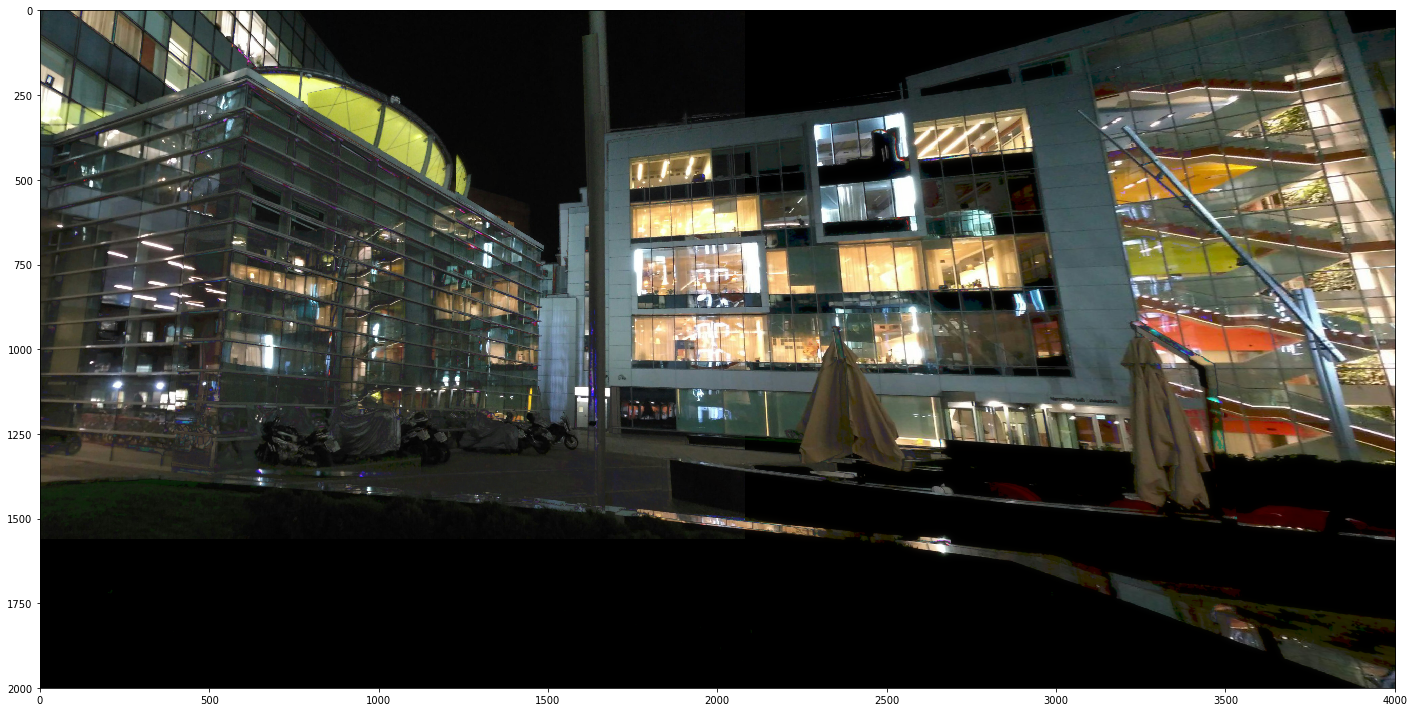

In [87]:
plt.figure(figsize=(20, 20))
sorted_images = read_and_sort_images('./img4')
tf_imgs = transform_images(sorted_images, 3)
io.imshow(illustrate_panoram(tf_imgs))

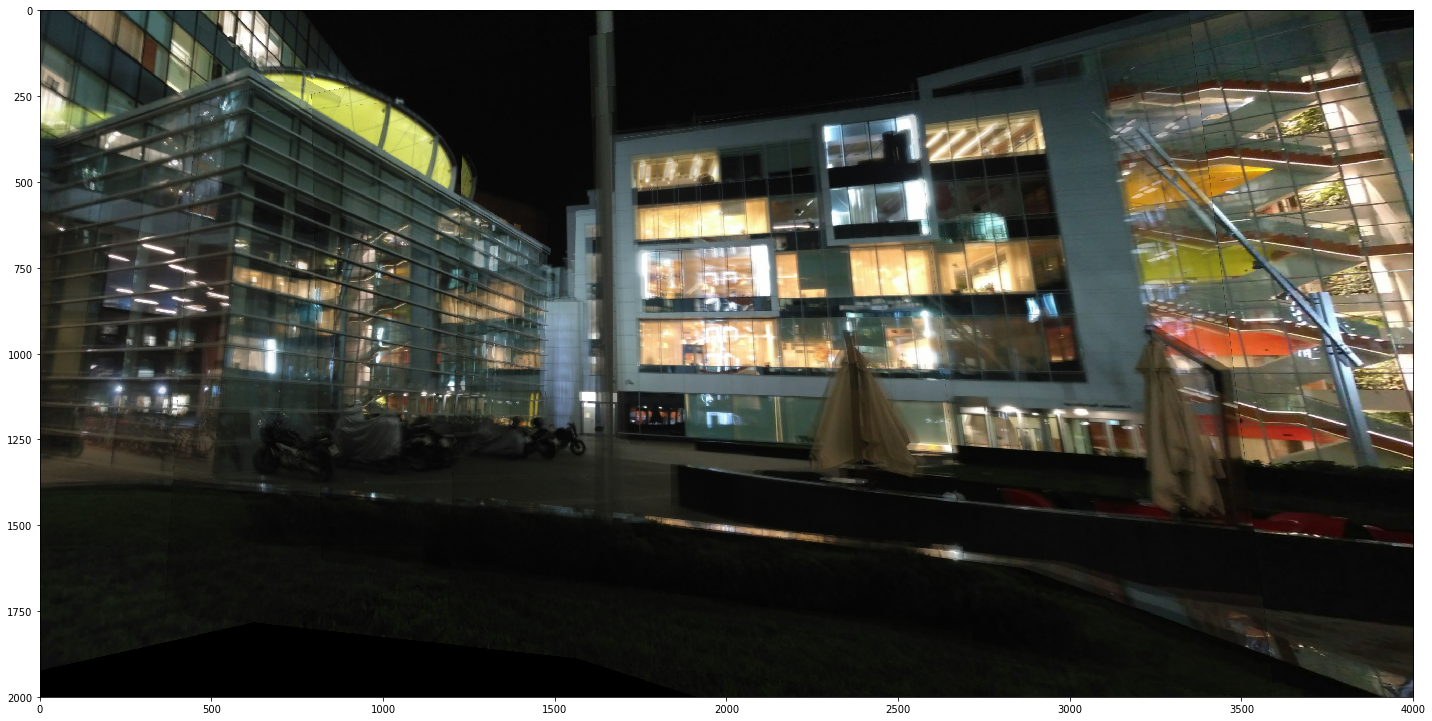

In [125]:
plt.figure(figsize=(20, 20))
io.imshow(illustrate_panoram(tf_imgs, with_pyramid=False))

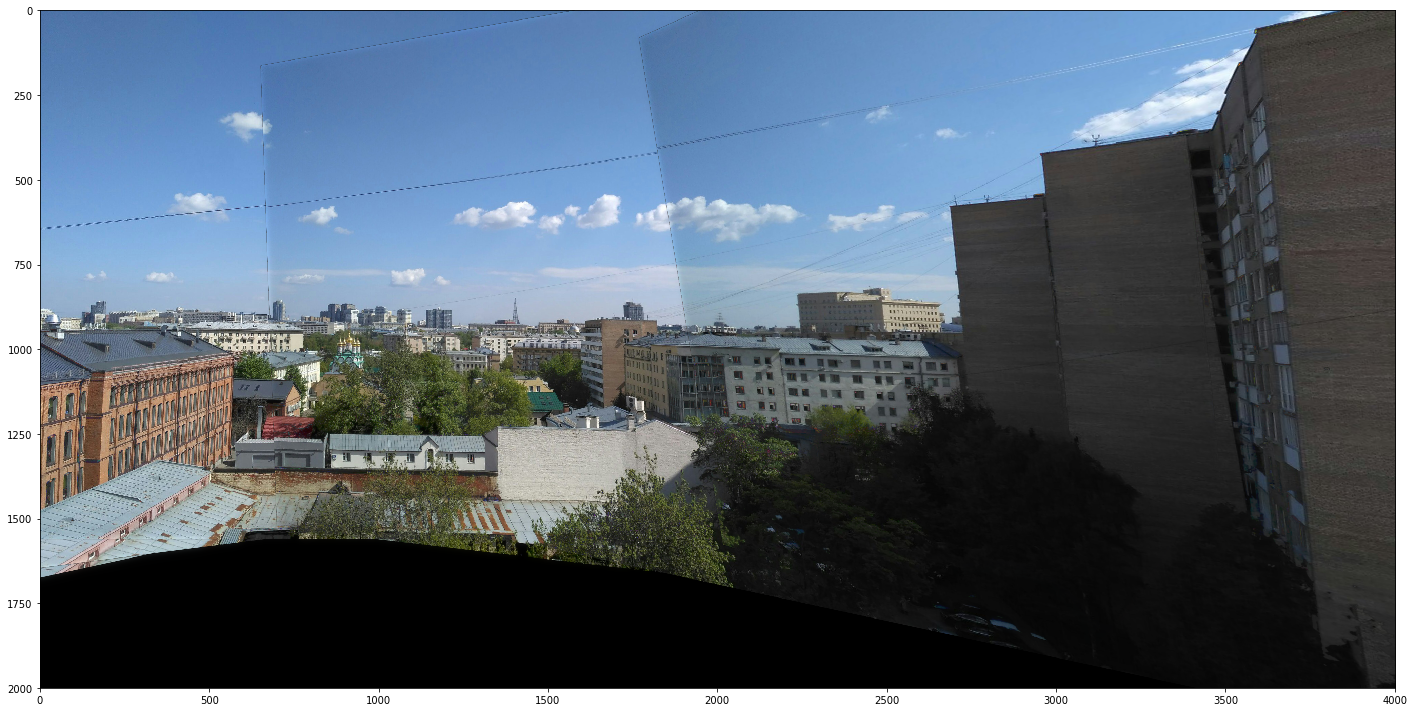

In [81]:
plt.figure(figsize=(20, 20))
sorted_images = read_and_sort_images('./img2/')
tf_imgs = transform_images(sorted_images, 4)
io.imshow(illustrate_panoram(tf_imgs))